## Time Series Forecasting : ARIMA vs Prophet

In [1]:
#Importing required Libraries
import numpy as np
import pandas as pd
from pandas import read_csv
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

C:\Users\nicol\anaconda3\envs\piia\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Read the dataset
file_name = 'maregraphie_csv_4_2020_2021.csv'
data_ = read_csv(file_name, header=0, index_col=0, parse_dates=True, squeeze=True)
data = data_.drop(columns=['Source'])
dfcol = ['Valeur']
data = data.resample('H').mean()
data

,Valeur
Date,
2020-01-02 00:00:00,3.705
2020-01-02 01:00:00,3.209
2020-01-02 02:00:00,2.844
2020-01-02 03:00:00,2.822
2020-01-02 04:00:00,3.388
...,...
2021-12-31 19:00:00,2.316
2021-12-31 20:00:00,1.826
2021-12-31 21:00:00,2.082


array([<AxesSubplot:xlabel='Date'>], dtype=object)

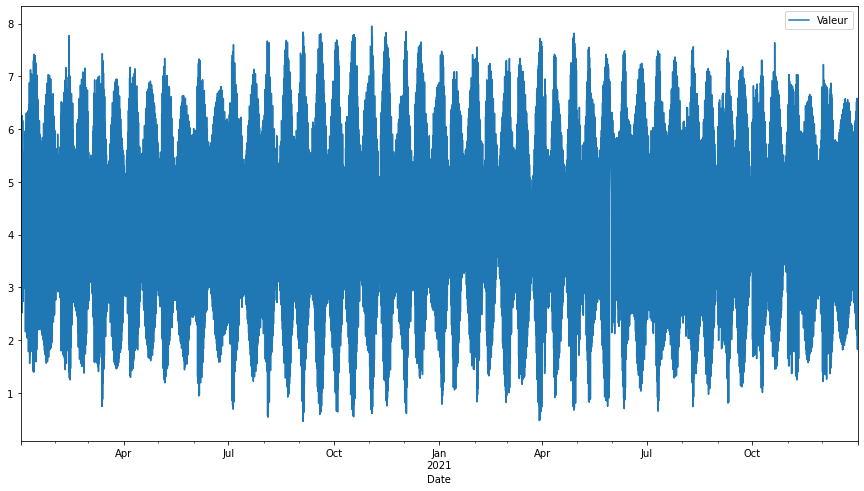

In [3]:
preprocessed = data.copy()
for key in preprocessed.keys():
    temp = preprocessed[key]
    nan_index = temp.isnull()
    temp = temp.interpolate('linear')
    results = seasonal_decompose(temp, period=24*30*12, model='additive', extrapolate_trend='freq')
    for i, real in enumerate(nan_index):
        if real == True:
            results.trend.iloc[i] = np.nan
            dt = str(results.resid.index[i])
            results.seasonal.iloc[i] = results.seasonal.loc[dt]
            results.resid.iloc[i] = results.resid.loc[dt]
            
    preprocessed[key] = results.trend.interpolate('linear') + results.seasonal + results.resid

preprocessed.plot(figsize=(15, 8), subplots=True)

In [4]:
#ARIMA Forecast
#Finding the best values for p,q,d,P,Q,D

auto_arima(preprocessed['Valeur'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

KeyboardInterrupt: 

In [ ]:
#Train-Test split
split = round(len(preprocessed)*0.8)
train_data = preprocessed[:split]
test_data = preprocessed[split:]
arima_model = SARIMAX(train_data['Valeur'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

In [10]:
#Prediction
arima_pred = arima_result.predict(start = len(train_data), end = len(data)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2021-08-08 00:00:00    3.542534
2021-08-08 01:00:00    4.677876
2021-08-08 02:00:00    5.677641
2021-08-08 03:00:00    6.324792
2021-08-08 04:00:00    6.445932
                         ...   
2021-12-31 19:00:00    4.209166
2021-12-31 20:00:00    4.209157
2021-12-31 21:00:00    4.209153
2021-12-31 22:00:00    4.209156
2021-12-31 23:00:00    4.209164
Freq: H, Name: ARIMA Predictions, Length: 3504, dtype: float64

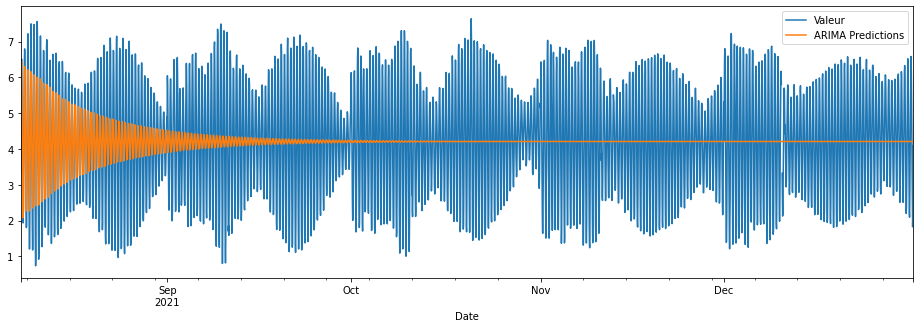

In [11]:
test_data['Valeur'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [10]:
#Model Evaluation
arima_rmse_error = rmse(test_data['Monthly_Prod'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Monthly_Prod'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 66.0245106602725
RMSE Error: 8.125546791464098
Mean: 136.39537815126045


In [11]:
test_data['ARIMA_Predictions'] = arima_pred

In [ ]:
#Prophet

In [18]:
df_pr = data.copy()
df_pr = data.reset_index()
df_pr.columns = ['ds','y'] # To use prophet column names should be like that
train_data_pr = df_pr.iloc[:split]
test_data_pr = df_pr.iloc[split:]

In [37]:
from prophet import Prophet
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=24, freq='H')
prophet_pred = m.predict(future)
prophet_pred.tail()
print(prophet_pred)

03:44:42 - cmdstanpy - INFO - Chain [1] start processing
03:44:44 - cmdstanpy - INFO - Chain [1] done processing


                       ds     trend  yhat_lower  yhat_upper  trend_lower  \
0     2020-01-02 00:00:00  4.247473    1.853278    5.647395     4.247473   
1     2020-01-02 01:00:00  4.247464    1.922291    5.778107     4.247464   
2     2020-01-02 02:00:00  4.247455    2.362174    6.209571     4.247455   
3     2020-01-02 03:00:00  4.247445    2.671617    6.478294     4.247445   
4     2020-01-02 04:00:00  4.247436    2.895210    6.885506     4.247436   
...                   ...       ...         ...         ...          ...   
14035 2021-08-08 19:00:00  4.191066    2.671014    6.292951     4.191066   
14036 2021-08-08 20:00:00  4.191051    2.194036    6.167410     4.191051   
14037 2021-08-08 21:00:00  4.191036    1.947157    5.535400     4.191036   
14038 2021-08-08 22:00:00  4.191021    1.562268    5.349552     4.191021   
14039 2021-08-08 23:00:00  4.191006    1.543395    5.500590     4.191006   

       trend_upper  additive_terms  additive_terms_lower  \
0         4.247473       -0

In [38]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-3504:]['ds'], "Pred" : prophet_pred[-3504:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "H"
prophet_pred

,Pred
Date,
2021-03-16 00:00:00,3.621939
2021-03-16 01:00:00,3.881882
2021-03-16 02:00:00,4.236786
2021-03-16 03:00:00,4.591867
2021-03-16 04:00:00,4.850810
...,...
2021-08-08 19:00:00,4.538945
2021-08-08 20:00:00,4.178275
2021-08-08 21:00:00,3.823859


In [39]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

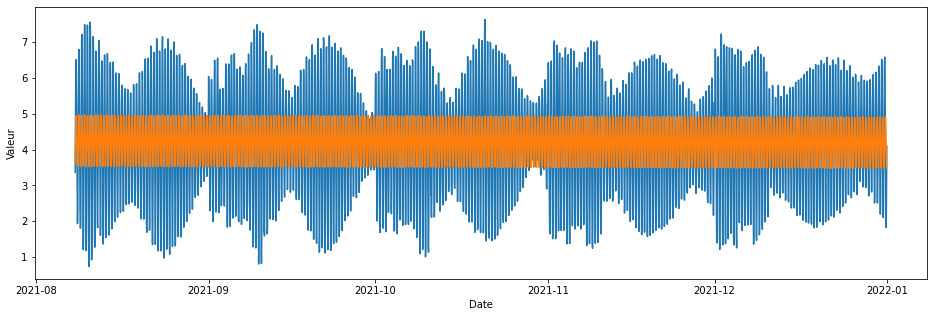

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["Valeur"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

In [36]:
prophet_rmse_error = rmse(test_data['Valeur'], prophet_pred['Pred'].values)
prophet_mse_error = prophet_rmse_error**2
mean_value = data['Valeur'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

ValueError: operands could not be broadcast together with shapes (3504,) (12,) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


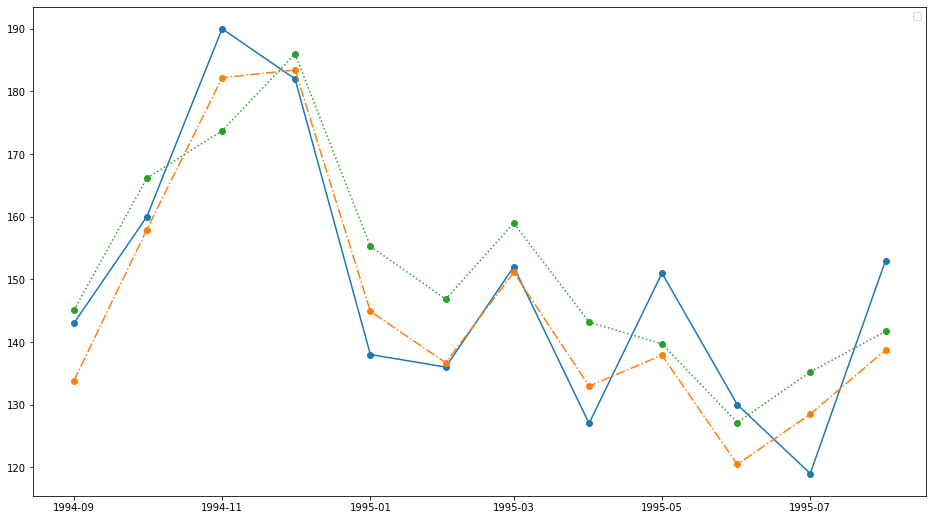

In [18]:
#Comparison

rmse_errors = [arima_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["Monthly_Prod"], linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()

In [19]:
print(f"Mean: {test_data['Monthly_Prod'].mean()}")
errors

Mean: 148.41666666666666


,Models,RMSE Errors,MSE Errors
0,ARIMA,8.125547,66.024511
1,Prophet,11.456032,131.240668


In [20]:
#Final Prediction data
test_data

,Monthly_Prod,ARIMA_Predictions,Prophet_Predictions
Month,,,
1994-09-01,143.0,133.802326,145.075294
1994-10-01,160.0,157.947991,166.143910
1994-11-01,190.0,182.189621,173.739726
1994-12-01,182.0,183.432999,185.996243
1995-01-01,138.0,144.897136,155.268002
1995-02-01,136.0,136.692542,146.852516
1995-03-01,152.0,151.119777,158.983574
1995-04-01,127.0,132.960930,143.175025
1995-05-01,151.0,137.891726,139.703713
